[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/Homeworks/blob/main/Task_2.ipynb)

# Задание
* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить результаты в pandas dataframe
<hr>

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:
-- Привести колонки датафрейма к одному типу данных
-- Проверить индекс, чтобы он соответствовал порядку строк
-- Проверить наличие пропусков и в случае обнаружения, определить стратегию их обработки
<hr>

* Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.
-- Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены.
-- Рассчитать объемы вводимого жилья по регионам и по годам.
-- Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах
-- Визуализировать разброс, связь и распределение этих показателей по регионам
-- Сделать выводы по каждому из расчетов и графиков

In [1]:
# Импорт библиотек
import requests
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import plotly
import plotly.express as px
from turtle import title
import math

In [2]:
# Ограничение вывода строк на экран
pd.options.display.max_rows = 120

# Формирование датасета

## Список объектов

In [ ]:
# Для скачивания данных по блоками по 100
# Задание параметров: начальное смещение равно 1, количество записей в блоке равно 100
offset_ = 0
limit_ = 100
# Пустой список ID объектов
objids = []
# Цикл из 1 млн итераций по 100 объектов (до 100млн домой, на сайте их 10583)
for i in range(1000000):
# Выполняем запрос к сайту, выдергиваем json
    try:
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
        res = requests.get(url)
        objects_data = res.json()
# Проверяем, есть ли в ответе объект
        objects_data.get('data').get('list')[0]
# Объекта нет - прерываем цикл
    except IndexError:
#        print('прерывание')
        break
# Не возникло исключение - берем ID объектов и добавляем их в список objids
    else:
        objects_list = objects_data.get('data').get('list')
        objids.extend([x.get('objId') for x in objects_list])
# увеличиваем смещение на 100
        offset_ += 100

In [ ]:
# Определяем количество строящихся объектов на сайте
url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset=0&limit=10&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
res = requests.get(url)
total = res.json().get('data').get('total')

# Задание параметров: начальное смещение равно 1, количество записей в блоке равно 100
offset_ = 0
limit_ = 100
# Пустой список ID объектов
objids = []
# Цикл выполняется, пока смещение не превысит общее количество объектов
while offset_ <= total:
# Выполняем запрос к сайту, выдергиваем json
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    res = requests.get(url)
# Берем ID объектов и добавляем их в список objids
    objects_list = res.json().get('data').get('list')
    objids.extend([x.get('objId') for x in objects_list])
# увеличиваем смещение на 100
    offset_ += 100

## Данные по определенному объекту

In [ ]:
# Для скачивания данных по определенному объекту, нужно добавить его id в конец строки запроса
res_full = []
# Для каждого объекта в списке objids
for ID_obj in tqdm(objids):
# Получение информации
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{ID_obj}'
    res = requests.get(url)
# Добавление в итоговый список
    res_full.append(res.json().get('data'))
# СОздание датафрейма
df = pd.json_normalize(res_full)
df

## Сохранение результатов

In [ ]:
# Сохранение результатов в excel
df.to_excel("ndrf_df.xlsx", encoding='cp1251')

In [ ]:
# Сохранение результатов в pickle
df.to_pickle("ndrf_df.pkl")

In [ ]:
# Создание базы данных SQLite
con = sqlite3.connect("ndrf_df.db")

# Приведение датафрейма к строковому типу (иначе SQL ругается)
df = df.astype('str')

# Сохранение датафрейма в таблицу buildings
df.to_sql("buildings", con, if_exists="replace", index=False)
con.commit()
con.close()


In [4]:
# Открываем базу данных SQLite
con = sqlite3.connect("ndrf_df.db")

# Проверка того, как данные выгрузились в БД
df1 = pd.read_sql("SELECT * FROM buildings", con)
con.commit()
con.close()
df1.head(3)

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,developer.bankruptStage.bankruptStageDesc,developer.bankruptStage.bankruptLawUrl,developer.orgBankruptMsgDttm,metro.id,metro.name,metro.line,metro.color,metro.time,metro.isWalk,metro.colors
0,29679,124647,61,г Таганрог,18,2020-03-31,Другое,Под ключ,Есть,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Для оптимизации времени используем ранее полученный результат

In [180]:
# Импорт датафрейма из файла, полученного в результате выполнения 1 задания
df = pd.read_pickle('ndrf_df.pkl')
df.shape

(10585, 108)

# Предварительная обработка данных

## Удаление неинформативных столбцов и строк

In [181]:
# Индекс соответствует порядку строк
df.index

RangeIndex(start=0, stop=10585, step=1)

In [182]:
# Есть столбец objPriceAvg, который характеризует среднюю цену за квадратный метр
# Удаляем строки, в которых средняя цена за квадратный метр отсутствует
df = df[df.objPriceAvg.notnull()]
df.shape

(7729, 108)

In [183]:
# Сбрасываем индекс
df.reset_index(inplace=True)
del df['index']
df.index

RangeIndex(start=0, stop=7729, step=1)

In [184]:
# Смотрим столбцы, в которых более 90% пропущенных значений
col_nul_sum = df.isnull().sum(axis=0)
col_nul_sum[col_nul_sum.values > 0.9*len(df)]

complexShortNm                               7025
developer.bankruptStage.bankruptStageCd      7682
developer.bankruptStage.bankruptStageDesc    7682
developer.bankruptStage.bankruptLawUrl       7682
developer.orgBankruptMsgDttm                 7682
metro.id                                     7728
metro.name                                   7728
metro.line                                   7728
metro.color                                  7728
metro.time                                   7728
metro.isWalk                                 7728
metro.colors                                 7728
dtype: int64

In [185]:
# Специфичных для регионов столбцов нет - их можно удалить
df.dropna(thresh=(0.1*len(df)), axis=1, inplace=True)
df.head(3)

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndex,transportDistIndexValue,nameObj,greenAreaIndexValue,airQualityIndexValue
0,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,34.0,0.0,68.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
1,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,35.0,6.0,65.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN
2,13399,28141,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
# Найдем столбцы с 1 значением
for i in df.columns:
    if df[i].value_counts().count() == 1:
        print(df[i].value_counts())

0    7729
Name: objProblemFlg, dtype: int64
12-09-2022 01:26    7729
Name: loadDttm, dtype: int64
normal    7729
Name: objectType, dtype: int64
0    7729
Name: objStatus, dtype: int64


In [187]:
# Удалим эти столбцы
for i in df.columns:
    if df[i].value_counts().count() == 1:
        del df[i]
df.head(3)

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndex,transportDistIndexValue,nameObj,greenAreaIndexValue,airQualityIndexValue
0,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,34.0,0.0,68.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
1,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,35.0,6.0,65.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN
2,13399,28141,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
# Посмотрим на столбцы которые остались
df.head().T

,0,1,2,3,4
id,13383,13397,13399,13398,13391
pdId,28105,28141,28141,28141,28101
region,72,72,72,72,72
address,г Тюмень,"г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная"
objElemLivingCnt,68,65,0,43,44
objReady100PercDt,2022-12-31,2024-12-31,2024-12-31,2024-12-31,2022-12-31
wallMaterialShortDesc,Другое,Другое,Другое,Другое,Другое
objLkFinishTypeDesc,По желанию заказчика,Без отделки,Без отделки,Без отделки,По желанию заказчика
objLkFreePlanDesc,Есть,Нет,Нет,Нет,Есть
objElemParkingCnt,31,0,125,0,41


In [189]:
# Удалим неинформативные столбцы
del df['id']                                # ID объекта на портале
del df['pdId']                              # ID проекта на портале
del df['rpdNum']                            #  № проекта
del df['rpdPdfLink']                        # ссылка на проектную документацию
del df['rpdIssueDttm']                      # Выпуск проектной документации
del df['objLkLatitude']                     # Координаты дома
del df['objLkLongitude']                    # Координаты дома
del df['photoRenderDTO']                    # Фотографии
del df['newBuildingId']                     # ID здания
del df['objFlatSq']                         # площадь квартир соответствует жилой площади
del df['objectTransportInfo']               # почти везде пустой список
del df['floorMin']                          # Минимальный этаж
del df['floorMax']                          # Максимальный этаж
del df['miniUrl']                           # URL
del df['objTransferPlanDt']                 # Дата выдачи ключей - не берем, так как есть дата ввода в эксплуатацию
del df['developer.devId']                   # Информация о застройщике
del df['developer.devShortNm']              # Информация о застройщике
del df['developer.devShortCleanNm']         # Информация о застройщике
del df['developer.devFullCleanNm']          # Информация о застройщике
del df['developer.buildObjCnt']             # Информация о застройщике
del df['developer.comissObjCnt']            # Информация о застройщике
del df['developer.regRegionDesc']           # Информация о застройщике
del df['developer.devPhoneNum']             # Информация о застройщике
del df['developer.devSite']                 # Информация о застройщике
del df['developer.devEmail']                # Информация о застройщике
del df['developer.devInn']                  # Информация о застройщике
del df['developer.devOgrn']                 # Информация о застройщике
del df['developer.devKpp']                  # Информация о застройщике
del df['developer.devLegalAddr']            # Информация о застройщике
del df['developer.devFactAddr']             # Информация о застройщике
del df['developer.lastRpdId']               # Информация о застройщике
del df['developer.devOrgRegRegionCd']       # Информация о застройщике
del df['developer.devEmplMainFullNm']       # Информация о застройщике
del df['developer.orgForm.id']              # Информация о застройщике
del df['developer.orgForm.fullForm']        # Информация о застройщике
del df['developer.orgForm.shortForm']       # Информация о застройщике
del df['objInfrstrObjPrkngCnt']
del df['objInfrstrNotObjPrkngCnt']          # Гостевые парковочные места на объекта
del df['generalContractorNm']               # Гостевые парковочные места вне объекта
del df['objLkSaleDepEmail']                 # Информация о застройщике
del df['developer.developerGroupName']      # Информация о застройщике
del df['developer.companyGroupId']          # Информация о застройщике
del df['quartography.objLivElem1KCnt']      # Количество 1-комнатных квартир в доме
del df['quartography.objLivElem2KCnt']      # Количество 2-комнатных квартир в доме
del df['quartography.objLivElem3KCnt']      # Количество 3-комнатных квартир в доме
del df['quartography.objLivElem4KCnt']      # Количество 4-комнатных квартир в доме
del df['transportDistIndex']                # дублирует transportDistIndexValue
del df['nameObj']                           # имя объекта
df.head(3)

,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,objCompensFundFlg,...,objElevatorCargoCnt,soldOutPerc,objPriceAvg,nonlivFirstFloor,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndexValue,greenAreaIndexValue,airQualityIndexValue
0,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,6293.78,1,...,1.0,0.407164,53109.0,1.0,68.0,1.0,6.0,NaN,NaN,NaN
1,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,6248.51,0,...,4.0,0.999984,45523.0,0.0,65.0,4.0,3.0,NaN,NaN,NaN
2,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,0.00,0,...,7.0,0.917243,50768.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


## Добавление столбцов

In [190]:
# Добавим столбец с годом ввода в эксплуатацию
df.insert(1, 'year_expl', df.objReady100PercDt.str.split('-', expand = True)[0])

# Приведем год ввода в эксплуатацию к числовому типу
df.year_expl = df.year_expl.astype('int')
df.year_expl.dtype

# Приведем дату ввода в эксплуатацию к формату даты
df['objReady100PercDt'] = pd.to_datetime(df['objReady100PercDt'], format="%Y-%m-%d")

In [191]:
# Добавим столбец с городом
df.insert(1, 'city', df.address.str.split(',', expand = True)[0])

# Адрес можно удалить
del df['address']

df.head(3)

,region,city,year_expl,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,...,objElevatorCargoCnt,soldOutPerc,objPriceAvg,nonlivFirstFloor,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndexValue,greenAreaIndexValue,airQualityIndexValue
0,72,г Тюмень,2022,68,2022-12-31,Другое,По желанию заказчика,Есть,31,6293.78,...,1.0,0.407164,53109.0,1.0,68.0,1.0,6.0,NaN,NaN,NaN
1,72,г Тюмень,2024,65,2024-12-31,Другое,Без отделки,Нет,0,6248.51,...,4.0,0.999984,45523.0,0.0,65.0,4.0,3.0,NaN,NaN,NaN
2,72,г Тюмень,2024,0,2024-12-31,Другое,Без отделки,Нет,125,0.00,...,7.0,0.917243,50768.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
# Делаем копию столбца с регионами в числовом виде для сортировки на графике
df['region_int'] = df['region'].copy()

# Сам регион приводим к строковому типу
df.region = df.region.astype('str')
(df.region_int.dtype, df.region.dtype)

(dtype('int64'), dtype('O'))

In [193]:
# В диапазоне высоты потолков

# Минимальное значение высоты потолков (первое значение диапазона высоты потолков)
df['objLivCeilingHeight_min'] = df.objLivCeilingHeight.str.split(' - ', expand = True)[0]
# Приводим к числовому типу
df['objLivCeilingHeight_min'] = df['objLivCeilingHeight_min'].str.replace(',','.')
df['objLivCeilingHeight_min'] = df['objLivCeilingHeight_min'].astype('float')

# Максимальное значение высоты потолков (второе значение диапазона высоты потолков)
df['objLivCeilingHeight_max'] = df.objLivCeilingHeight.str.split(' - ', expand = True)[1]
# Если высота потолков не диапазон, а одно значение - берем единственное значение
df['objLivCeilingHeight_max'] = df['objLivCeilingHeight_max'].fillna(df['objLivCeilingHeight'])
# Приводим к числовому типу
df['objLivCeilingHeight_max'] = df['objLivCeilingHeight_max'].str.replace(',','.')
df['objLivCeilingHeight_max'] = df['objLivCeilingHeight_max'].astype('float')

# Средняя вытота потолков (среднее арифметическое между максимальным и минимальным)
df['objLivCeilingHeight_avg'] = df.apply(lambda x: (x.objLivCeilingHeight_min + x.objLivCeilingHeight_max) / 2, axis=1)

# Проверяем, что значения не потерялись
(df['objLivCeilingHeight_min'].notnull().sum(), df['objLivCeilingHeight_max'].notnull().sum(), df['objLivCeilingHeight_avg'].notnull().sum())

(7014, 7014, 7014)

In [194]:
# Пока коряво - при применении apply при возникновении исключения столбец не формируется

# Добавим столбец с относительным количеством парковочных мест (количество парковочных мест на квартиру)
df['objElemParkingCnt_otn'] = np.NaN
for i in range(len(df)):
   # if df['objElemParkingCnt'][i] == 0:
    #    df['objElemParkingCnt_otn'] = 0
   # elif ['objFlatCnt'] == 0:
  #      break
 #   else:
    try:
        df['objElemParkingCnt_otn'][i] = df['objElemParkingCnt'][i] / df['objFlatCnt'][i]
    except: pass

# Добавим столбец с относительным количеством детских площадок (количество детских площадок на квартиру)
df['objInfrstrPlaygrndCnt_otn'] = np.NaN
for i in range(len(df)):
 #   if df['objInfrstrPlaygrndCnt'][i] == 0:
 #       df['objInfrstrPlaygrndCnt_otn'] = 0
 #   elif ['objFlatCnt'] == 0:
 #       break
 #   else:
    try:
        df['objInfrstrPlaygrndCnt_otn'][i] = df['objInfrstrPlaygrndCnt'][i] / df['objFlatCnt'][i]
    except: pass

# Добавим столбец с относительным количеством спортивных площадок (количество спортивных площадок на квартиру)
df['objInfrstrSportGroundCnt_otn'] = np.NaN
for i in range(len(df)):
 #   if df['objInfrstrSportGroundCnt'][i] == 0:
 #       df['objInfrstrSportGroundCnt_otn'] = 0
 #   elif ['objFlatCnt'] == 0:
 #       break
 #   else:
    try:
        df['objInfrstrSportGroundCnt_otn'][i] = df['objInfrstrSportGroundCnt'][i] / df['objFlatCnt'][i]
    except: pass

C:\Users\User\AppData\Local\Temp\ipykernel_8840\3639434977.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_8840\3639434977.py:12: RuntimeWarning:

divide by zero encountered in longlong_scalars

C:\Users\User\AppData\Local\Temp\ipykernel_8840\3639434977.py:12: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\User\AppData\Local\Temp\ipykernel_8840\3639434977.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_8840\3639434977.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\User

# Сбор информации по вводу жилья и ценам по городам, регионам и годам

## Плащадь вводимого жилья по регионам и годам

In [195]:
# Создадим датафрейм с колонками регион, год ввода в эксплуатацию, жилая площадь объекта для построения диаграмм
df_region_sqr = df[['region', 'year_expl', 'objSquareLiving']].copy()

# Удалим строки с пустыми значениями
df_region_sqr.dropna(inplace=True)

# Рассчитаем вводимую в эксплуатацию площаль по регионам по годам
df_region_sqr_gr = df_region_sqr.groupby(['region','year_expl'])['objSquareLiving']
df_region_sqr['all_square'] = df_region_sqr_gr.transform(sum)
del df_region_sqr['objSquareLiving']
df_region_sqr.drop_duplicates(inplace=True)

# Удалим строки с нулевой общей площадью
df_region_sqr = df_region_sqr[df_region_sqr.all_square > 0]
df_region_sqr.head(3)

,region,year_expl,all_square
0,72,2022,484424.60
1,72,2024,416902.36
5,26,2022,120540.88


In [196]:
# Функция построения круговых диаграмм (бубликов) по годам
def region_sqr_all_years(ncol_param):
    
    # Список уникальных годов
    list_years = df_region_sqr.year_expl.unique()
    list_years.sort()

    # количество графиков по ширине
    ncol = ncol_param
    # количество графиков по высоте
    nrow = math.ceil(len(list_years)/ncol)
    
    # Строим графики
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, sharey=True)
    for i in range(len(list_years)):
        df_region_sqr_i = df_region_sqr[df_region_sqr.year_expl == list_years[i]].copy()
        
        # Регионы с малым процентом вводимого жилья группируем в Other regions
        df_region_sqr_i.loc[df_region_sqr_i['all_square'] < (df_region_sqr_i['all_square'].sum()) * 0.02, 'region'] = 'Other regions' # Represent only large countries
        df_region_sqr_i_gr = df_region_sqr_i.groupby(['region','year_expl'])['all_square']
        df_region_sqr_i['all_square'] = df_region_sqr_i_gr.transform(sum)
        df_region_sqr_i.drop_duplicates(inplace=True)   

        v1 = df_region_sqr_i['all_square']
        labels1 = df_region_sqr_i['region']
        width = 0.4 
        
        wedge_properties = {"width":width}
        ax[i//ncol,i%ncol].pie(v1,
                            labels=labels1,
                            wedgeprops=wedge_properties,
                            autopct="%1.1f%%", pctdistance=0.8)
        ax[i//ncol,i%ncol].set_title(str(list_years[i]) + ' год')
    fig.set_size_inches((4.5*ncol),(4.5*nrow))
    plt.subplots_adjust(wspace=0.3 )

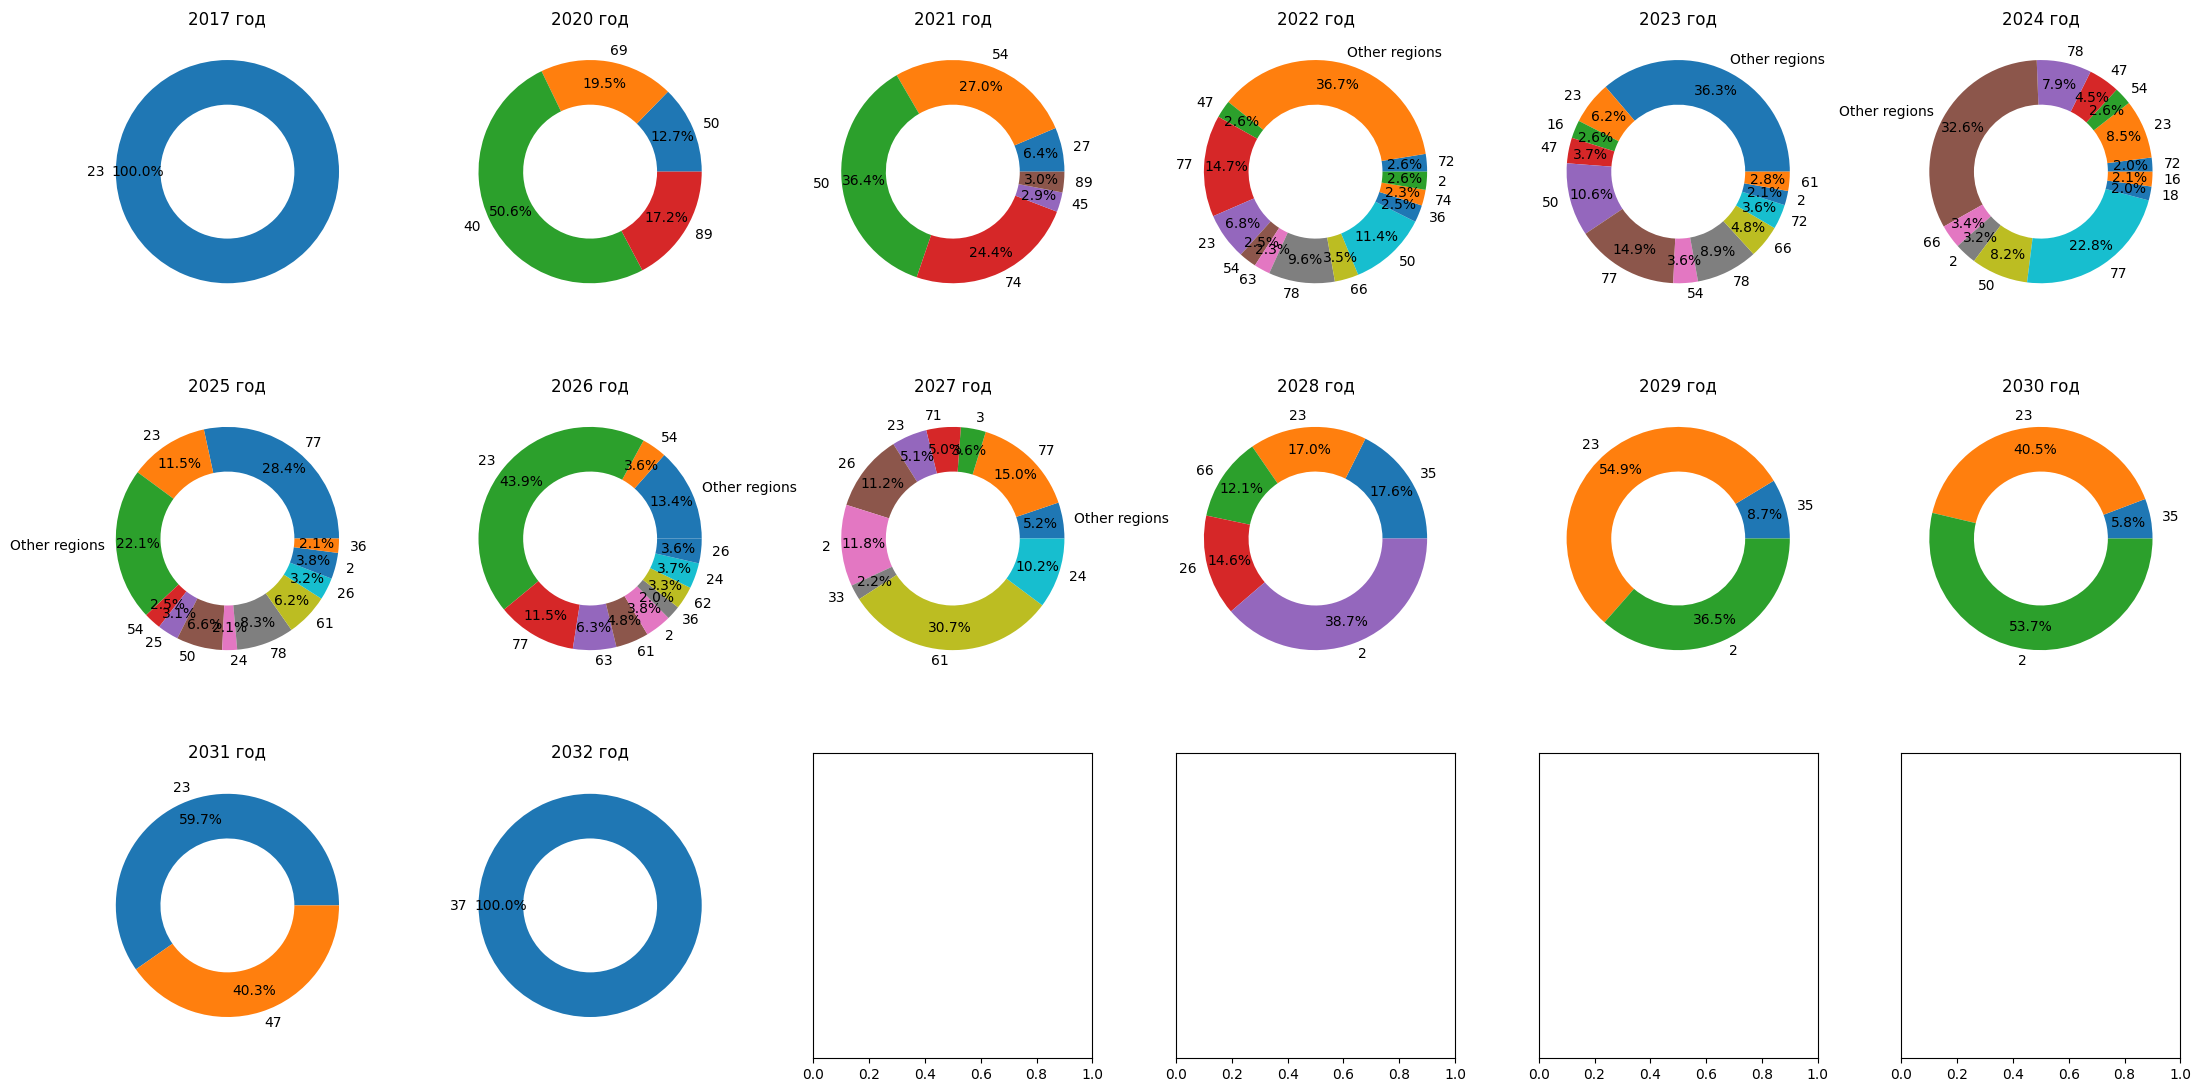

In [197]:
# Строим круговые диаграммы (бублики) по годам (на вход подаем количество бубликов по ширине)
region_sqr_all_years(6)

Выводы: Так как масштаб графиков небольшой, можно наблюдать общие тенденции: в 2022 - 2025 годах большая доля жилья вводится в эксплуатацию в Москве на дальнем горизонте доля вводимого жилья в Москве падает (вероятно начнут строиться позже в сжатые сроки и графики выровняются)

In [198]:
# Функция построения круговой диаграммы ввода жилья в эксплуатацию по регионам в зависимости от года
def region_sqr_year(year):
    df_region_sqr_per_year = df_region_sqr[df_region_sqr.year_expl == year].copy()
    # Регионы с вводом жилья менее 0.2% по стране группируем в Other regions для удобства восприятия графика
    df_region_sqr_per_year.loc[df_region_sqr_per_year['all_square'] < (df_region_sqr_per_year.all_square.sum() * 0.002), 'region'] = 'Other regions'
    fig = px.pie(df_region_sqr_per_year, values='all_square', names='region', width=1000, height=800, title=(str(year) + ' год'))
    fig.show()

In [199]:
# На вход подаем год, за который нужен график
region_sqr_year(2022)

Выводы даны на предыдущем графике, здесь можно посмотреть графики по годам отдельно, интерактивно и в большем масштабе

## Плащадь вводимого жилья по городам, регионам и годам

In [200]:
# Создадим датафрейм с колонками регион, город, год ввода в эксплуатацию, жилая площадь объекта для построения диаграммы sunburst
df_city_sqr = df[['region', 'city', 'year_expl', 'objSquareLiving']].copy()

# Удалим строки с пустыми значениями
df_city_sqr.dropna(inplace=True)

# Рассчитаем вводимую в эксплуатацию площаль по городам по годам
df_city_sqr_gr = df_city_sqr.groupby(['region','city','year_expl'])['objSquareLiving']
df_city_sqr['all_square'] = df_city_sqr_gr.transform(sum)
del df_city_sqr['objSquareLiving']
df_city_sqr.drop_duplicates(inplace=True)

# Удалим строки с пустой общей площадью
df_city_sqr = df_city_sqr[df_city_sqr.all_square > 0]
df_city_sqr.head(3)


,region,city,year_expl,all_square
0,72,г Тюмень,2022,262296.37
1,72,г Тюмень,2024,351144.12
5,26,г Ставрополь,2022,63983.15


In [201]:
# Функция построения круговой диаграммы ввода жилья в эксплуатацию по годам
def region_city_square(year):
    df_city_sqr_per_year = df_city_sqr[df_city_sqr.year_expl == year]
    fig = px.sunburst(df_city_sqr_per_year, path=['region', 'city'], values='all_square',color='all_square', hover_data=['all_square'], title=year, width=1000, height=800)
    fig.show()

In [202]:
# Строим график по нужному году
region_city_square(2026)


Выводы те же, что и по предыдущему графику. Из необычного - в Краснодарском крае много жилья строится в самом Краснодаре, а не в прибрежных городах

## Разброс стоимости строящегося жилья по регионам

In [203]:
# Диаграмма рассеивания цен на жилье по регионам
df_copy = df[['region', 'objPriceAvg', 'objLkClassDesc', 'region_int']].dropna().copy()
df_copy = df_copy.sort_values(by='region_int')
fig = px.scatter(df_copy, x='region', y='objPriceAvg', color='objLkClassDesc')
fig.show()

Вывод необычен:
* ожидаемо, в Москве самое дорогое жилье;
* вопреки ожиданиям, на втором месте по самому дорогому жилью (не по средней цене) - Краснодарский край 

In [204]:
# Другое представление цен за квадратный метр по городам (boxplot)
df_copy = df[['region', 'objPriceAvg', 'region_int']].dropna().copy()
df_copy = df_copy.sort_values(by='region_int')
fig = px.box(df_copy, y="objPriceAvg", x="region", hover_data=df_copy.columns)
fig.show()

Вывод: В Москве и Краснодарском крае просто дикие выбросы вверх по цене.

## Средняя стоимость жилья по регионам

In [205]:
# Посчитаем среднюю цену жилья по регионам

# Копия датафрейма для работы
df_region_avg = df[['region','objSquareLiving', 'objPriceAvg']].copy()

# Удалим строки с пустыми значениями
df_region_avg.dropna(inplace=True)

# Считаем стоимость всей площади объекта
df_region_avg['objPrice'] = df_region_avg.apply(lambda r: r.objSquareLiving * r.objPriceAvg, axis=1)

# Группируем датафрейм по региону, нужны столбцы objSquareLiving и objPrice
df_region_avg_gr = df_region_avg.groupby(['region'])[['objSquareLiving', 'objPrice']]
# Считаем суммы по стоимости всего жилья и всей площади
df_region_avg = df_region_avg_gr.agg([('sum', 'sum')])

# Считаем отношение стоимости всего жилья в регионе к площади всего жилья в регионе
df_region_avg['avg_price'] = df_region_avg.apply(lambda x: x.objPrice / x.objSquareLiving, axis=1)

# Оставляем для региона только столбец со средней ценой жилья
df_region_avg = df_region_avg.avg_price

# Округляем среднюю стоимость жилья до целого
df_region_avg = df_region_avg.astype('int')
df_region_avg = df_region_avg.sort_values()
df_region_avg = df_region_avg.reset_index()
df_region_avg.head()

,region,avg_price
0,5,25844
1,20,29971
2,15,47084
3,60,49781
4,8,50730


In [206]:
# Столбиковая диаграмма
fig = px.bar(df_region_avg, x="avg_price", y="region", width=1000, height=1300)
fig.show()

Вывод: насмотря на то, что второе место по самому дорогому жилью занимает Краснодарский край, на втором месте по средней стоимости жилья - Санкт-Петербург

## Сравнение иных показателей строящихся домов по регионам

In [207]:
# Функция построения графиков рассеивания по регионам
def Scatterplot_reg(param):
    df_copy = df[['region', param, 'objLkClassDesc', 'region_int']].dropna()
    df_copy = df_copy.sort_values(by='region_int')
    fig = px.scatter(df_copy, x='region', y=param, color='objLkClassDesc')
    fig.show()

Подаем на вход  поочередно столбцы датафрейма, смотрим на график, выбираем наиболее информативные

In [208]:
# Диаграмма рассеивания жилой площади объектов по регионам
Scatterplot_reg('objSquareLiving')

Вывод: самые большие по площади объекты строятся в Москве, МО и Питере. Выделяется еще ряд регионов, например 23, 36, 47. Магаданская область имеет наеменьшую площадь самого крупного объекта (немногим более 3к квадратов)

In [209]:
# Диаграмма рассеивания количества квартир в строящихся объектах по регионам
Scatterplot_reg('objFlatCnt')

Вывод: ожидаемо самые большие по количеству квартир строятся дома в Москве и Питере. Несколько отстают 23 (Краснодарский край), 36 (Воронежская область), 47 (Ленинградская область) и 50 (МО) регионы. На удивление не выделяется Свердловская область (Екатеринбург). Как и в площади более всего отстает Магаданская область (49 квартир)

In [210]:
# Диаграмма рассеивания сроков ввода в эксплуатацию объектов по регионам
Scatterplot_reg('objReady100PercDt')

Вывод: по срокам сдачи (дальние сроки сдачи) выделяются 2 (Республика Башкортостан), 23 (Краснодарский край) и 35 (Вологодская область) регионы

In [211]:
# Диаграмма рассеивания количества парковочных мест для объектов по регионам в абсолютном значении
Scatterplot_reg('objElemParkingCnt')

Вывод: количество парковочных мест (а абсолютном значении) для домов по регионам разнится; не очень информативно по причине разного количества квартир в домах по регионам

In [212]:
# Диаграмма рассеивания относительного количества парковочных мест для объектов по регионам
Scatterplot_reg('objElemParkingCnt_otn')

Вывод: относительное количество парковочных мест по регионам значительно отличается. Больше всего их в 54 (Новосибирская область), Москве и Санкт-Петербурге, однако Москва уже не так выделяется, как по абсолютному количеству. На удивление в МО относительно небольшое количество парковочных мест

In [213]:
# Диаграмма рассеивания количества детских площадок для строящихся объектов по регионам
Scatterplot_reg('objInfrstrPlaygrndCnt')

Вывод: более 10 детских площадок имеют отдельные дома в 23, 50,58, 68 и 77 регионах

In [214]:
# Диаграмма рассеивания относительного количества детских площадок для строящихся объектов по регионам (количество площадок на квартиру)
Scatterplot_reg('objInfrstrPlaygrndCnt_otn')

Вывод: по количеству детских площадок на квартиру выделяется МО. По факту это дома с жилой площадью ~ 1000 квадратов 3-7 квартир. Выбросы нерепрезентативны

In [215]:
# Диаграмма рассеивания количества спортивных площадок для строящихся объектов по регионам
Scatterplot_reg('objInfrstrSportGroundCnt')

Вывод: более 10 спортивных площадок имеют отдельные дома в 23, 50, 58, 68 и 77 регионах

In [216]:
# Диаграмма рассеивания количества спортивных площадок для строящихся объектов по регионам (количество площадок на квартиру)
Scatterplot_reg('objInfrstrSportGroundCnt_otn')

Вывод: в 23, 38 и 50 регионе много выбросов. Это дома площадью ~ 1000 квадратов на 3-4 квартиры. Они не репрезентативны

# Исследование строящегося жилья конкретном регионе

## Датафрейм с данными выбранного региона

In [217]:
# Функция формирования датафрейма для
def select_region(region):
    df_region = df[df.region == str(region)].copy()
    del df_region['region']                          # Код региона больше не нужен

    # Перестроим индекс
    df_region.reset_index(inplace=True)
    del df_region['index']
    return df_region

In [218]:
# Формируем датафрейм для нужного региона
df_region = select_region(77)
df_region.head()

,city,year_expl,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,objCompensFundFlg,...,transportDistIndexValue,greenAreaIndexValue,airQualityIndexValue,region_int,objLivCeilingHeight_min,objLivCeilingHeight_max,objLivCeilingHeight_avg,objElemParkingCnt_otn,objInfrstrPlaygrndCnt_otn,objInfrstrSportGroundCnt_otn
0,п Коммунарка,2022,99,2022-09-30,Монолит-кирпич,Без отделки,Нет,0,5589.50,0,...,2.0,5.0,6.0,77,2.99,2.99,2.990,0.000000,0.010101,0.010101
1,г Москва,2023,396,2023-06-30,Другое,Без отделки,Есть,0,20225.00,1,...,6.0,9.0,6.0,77,3.10,3.65,3.375,0.000000,0.002525,0.002525
2,г Москва,2023,204,2023-06-30,Монолит-кирпич,Под ключ,Нет,36,16726.99,1,...,4.0,8.0,6.0,77,2.87,3.55,3.210,0.176471,0.000000,0.000000
3,г Москва,2025,0,2025-09-30,Монолит-кирпич,Под ключ,Нет,389,0.00,0,...,5.0,8.0,NaN,77,NaN,NaN,NaN,inf,NaN,NaN
4,г Москва,2023,782,2023-12-31,Монолит-кирпич,Другое,Нет,558,68693.80,0,...,8.0,6.0,6.0,77,3.20,4.10,3.650,0.713555,0.002558,0.002558


# Построение диаграмм рассеивания для столбцов с характеристиками объекта и средней цены за кв. метр объекта

# Исследование столцов для диаграммы рассеивания

In [219]:
# Функция построения графиков рассеивания
def Scatterplot_Mos(param, inverse=0):
    df_copy = df_region[['objPriceAvg',param, 'objLkClassDesc']].dropna()
    df_copy = df_copy.sort_values(by=param)
    if inverse == 0:
        fig = px.scatter(df_copy, x=param, y='objPriceAvg', color='objLkClassDesc')
        fig.show()
    if inverse != 0:
        fig = px.scatter(df_copy, x='objPriceAvg', y=param, color='objLkClassDesc')
        fig.show()

In [220]:
# Подаем на вход  поочередно столбцы и смотрим на график
# Второй параметр - назначение осей:
#  0 - средняя цена - по вертикали (по умолчанию)
#  1 - по горизонтали
Scatterplot_Mos('objReady100PercDt', 0)

## Диаграмма рассеивания по цене и выбираемому параметру объекта

In [221]:
# Датафрейм с наибелее информативными столбцами для scatterplot
df_reg_scatter = df_region[['objElemParkingCnt', 'objElemParkingCnt_otn', 'objSquareLiving', 'objLkClassDesc', 'objFlatCnt', 'objNonlivElemCnt', 'infrastructureIndexValue', 'objFloorCnt',
'objInfrstrPlaygrndCnt', 'objInfrstrPlaygrndCnt_otn', 'objInfrstrSportGroundCnt', 'objInfrstrSportGroundCnt_otn', 'objInfrstrTrashAreaCnt', 'objElevatorWheelchairCnt', 'objElevatorPassengerCnt', 'objElevatorCargoCnt', 'soldOutPerc', 'objPriceAvg',
'quartography.objLivElemCnt', 'quartography.objLivElemEntrCnt', 'quartography.objLivElemEntrFloorAvg', 'transportDistIndexValue', 'objLivCeilingHeight_min', 'objLivCeilingHeight_max', 'objLivCeilingHeight_avg']].copy()

In [222]:
# Строим интерактивный график с выбором характеристики для оценки зависимости от нее цены
def scat_plotter(df_reg_scatter, param):
    df_reg_scatter_copy = df_reg_scatter[['objPriceAvg', param, 'objLkClassDesc']]
  # fig = px.scatter(df_reg_scatter_copy, x=param, y='objPriceAvg', color='objLkClassDesc')
   # fig.show()
    
    sns.relplot(x=param, 
            y='objPriceAvg', 
            aspect=3,
            hue='objLkClassDesc',    # помечаем цветом классы жилья
           # jitter=0.1,
          #  kind='strip', 
           # dodge=True,
            data=df_reg_scatter_copy);

def g(param):
    ''' Запускаем боксплот '''
    scat_plotter(df_reg_scatter, param)

In [223]:
# objLkClassDesc и objPriceAvg надо исключить из выпадающего списка
scat_plotter_param = list(df_reg_scatter.columns.copy())
scat_plotter_param.remove('objLkClassDesc')
scat_plotter_param.remove('objPriceAvg')

# Запускаем интерактивный график
interact(g, param=scat_plotter_param);

interactive(children=(Dropdown(description='param', options=('objElemParkingCnt', 'objElemParkingCnt_otn', 'ob…

На графике можно посмотреть зависимость цены от отдельных параметров и класса жилья. Вывод по 77 региону: по цене за квадрат очень сильно выделяются элетные объекты с малым количеством квартир (видимо загородные дома). На удивление цена за квадрат не зависит от процента постройки дома. На цену за квадрат очень сильно влияет индекс транспортной доступности. Видна некоторая зависимость по высоте потолков (низкие потолки в более дешевом жилье дешевого класса).

## График boxplot по цене и выбираемому параметру объекта

In [224]:
# Датафрейм с колонками для boxplot
df_reg_box = df_region[['year_expl', 'wallMaterialShortDesc', 'objLkFinishTypeDesc', 'objLkFreePlanDesc', 'objCompensFundFlg', 'objLkClassDesc', 'objGuarantyEscrowFlg', 'residentialBuildings', 'objInfrstrBicycleLaneFlg', 'objInfrstrRampFlg', 'objInfrstrCurbLoweringFlg', 'conclusion',
'objGreenHouseFlg', 'objEnergyEffShortDesc', 'infrastructureIndexValue', 'developer.fundGuarantyFlg', 'developer.objGuarantyEscrowFlg', 'objPriceAvg', 'nonlivFirstFloor', 'transportDistIndexValue', 'greenAreaIndexValue', 'airQualityIndexValue']].copy()

In [225]:
# Строим интерактивную диаграмму рассеивания с выбором характеристики для оценки зависимости от нее цены
def box_plotter(df_reg_box, param):
    df_reg_box_copy = df_reg_box[['objPriceAvg', param]]
    sns.catplot(x=param, 
            y='objPriceAvg', 
            aspect=2,
            kind="box",
            showfliers=False,
            data=df_reg_box_copy);

def f(param):
    ''' Запускаем боксплот '''
    box_plotter(df_reg_box, param)

In [226]:
# objPriceAvg надо исключить из выпадающего списка
box_plotter_param = list(df_reg_box.columns.copy())
box_plotter_param.remove('objPriceAvg')

# Запускаем интерактивный график
interact(f, param=box_plotter_param);

interactive(children=(Dropdown(description='param', options=('year_expl', 'wallMaterialShortDesc', 'objLkFinis…

На графике можно посмотреть зависимость цены от отдельных параметров и класса жилья. Вывод по 77 региону: на удивление с более дальними годами ввода жилья растет медана цены, но при этом нижняя граница цены ниже. Кирпичные дома наиболее дороги за квадрат, что, вероятно, связано с тем, что это загородные дома. На удивление квартиры под ключ дешевле квартир без отделки. Квартиры со свободной планировкой дороже. Странно, что квартиры в домах с велодорожками дешевле. Дома с низкой энергоэффективностью дешевле. Сильно на цену влияют индекс инфраструктуры, транспортной доступности и озеленения. Очень странно, что при росте индекса качества воздуха с 6 до 8 растет цена за квадрат, а при 9 и 10 цена ниже, чем при качестве 6-8. В домах с нежилым первым этажом квартиры дороже.

P.s. По регионам (32) картина сильно отличается. По многим параметрам закономерности нет. По ряду паараметров выводы противоположные (например, отделка, материал стен)